In [ ]:
include("../dependencies.jl")
include("ldpc_tanner_loops.jl")
push!(LOAD_PATH, "../functions/")
using BP, Ising2D
using Random, Plots, SparseArrays
import StatsBase

## Utilities

In [8]:
function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function get_nbrs_of_check(adj_mat, v)
    ## get nbrs of node v from adj_mat
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_nbrs_of_data(adj_mat, v)
    ## get nbrs of node v from adj_mat
    col = adj_mat[:, v]
    return findall(x -> x == 1, col)
end


function bit_to_onehot(x;pbias=0.5)
    if x == 0
        return [2, 0]
    elseif x == 1
        return [0, 2]
    elseif x == -1
        return 2 .* [1-pbias, pbias]
    else
        error("Input must be -1, 0, or 1")
    end
end




bit_to_onehot (generic function with 1 method)

## PCmat to TN

In [9]:
function get_network(pcmat, syndrome)
    ## pcmat: (n-k) x (n)
    ## syndrome: (n-k)
    ## close syndrome legs with given syndrome, keeps data legs open for later
    m, n = size(pcmat)
    k = n - m 
    indmat = [Index(2, "s$(i)d$(j)") for i in 1:m, j in 1:n]
    datainds = [Index(2, "x$i") for i in 1:n]
    data_tensors = []
    syn_tensors = []

    ## data data_tensors

    for i = 1:n 
        checks = get_nbrs_of_data(pcmat,i)
        indxs = [indmat[jj,i] for jj in checks]
        push!(indxs,datainds[i])
        push!(data_tensors,delta(indxs))
    end 

    ## check tensors 
    for j = 1:m
        datas = get_nbrs_of_check(pcmat,j)
        tensor = parity_tensor([indmat[j,ii] for ii in datas],syndrome[j])
        push!(syn_tensors,tensor)
    end 
    return data_tensors, syn_tensors, datainds
end 

function get_marginal_data_tensors(data_tensors,data_indices,data_inputs;pbias=0.5,exclude=[])
    N = length(data_tensors)
    marginalized = []
    for i = 1 : N 
        if !(i in exclude)
            tens = data_tensors[i] *  ITensor(bit_to_onehot(data_inputs[i];pbias=pbias),data_indices[i])
        else 
            tens = data_tensors[i] 
        end 
        push!(marginalized,tens)
    end 
    return marginalized
end 

function replace_at_index(arr, index, new_val)
    arr_copy = deepcopy(arr)       # Step 1: copy original array
    arr_copy[index] = new_val  # Step 2: replace value at index
    return arr_copy            # Step 3: return new array with update
end

function sample_bit(p0)
    return rand() < p0 ? 0 : 1
end


sample_bit (generic function with 1 method)

## Gallager $(d_v,d_c)$ code p.c. matrix

In [10]:
"""
    gallager_ldpc_matrix(n::Int, d_v::Int, d_c::Int)

Generate a regular (d_v, d_c) LDPC parity-check matrix using Gallager construction.

# Arguments
- `n`: Number of bits (columns)
- `d_v`: Number of ones per column (column weight)
- `d_c`: Number of ones per row (row weight)

# Returns
- `H`: A sparse parity-check matrix of size m × n
"""
function gallager_ldpc_matrix(n::Int, d_v::Int, d_c::Int)
    # Ensure total ones are compatible
    if n * d_v % d_c != 0
        error("n*d_v must be divisible by d_c")
    end
    m = (n * d_v) ÷ d_c  # number of rows

    # Initialize empty matrix
    H = spzeros(Int8, m, n)

    # First, build the base structure
    rows_per_group = m ÷ d_v
    for i in 0:(d_v-1)
        perm = randperm(n)
        for j in 1:rows_per_group
            row = i * rows_per_group + j
            cols = perm[((j-1)*d_c + 1):(j*d_c)]
            H[row, cols] .= 1
        end
    end

    return H
end
 

gallager_ldpc_matrix

## BP decoding sim given a pcmat

In [11]:
function get_marginal(tensors,adj_mat,messages,index)
    nbrs = BP.get_nbrs(adj_mat, index)
    Z_local = tensors[index] 
    for nbr in nbrs
        Z_local *= messages[nbr,index] 
    end
    return Z_local
end 

function _code_sim_simple(pcmat, p, num_samples)
    m, n = size(pcmat)
    println("p = $p, N = $n")
    k = n - m
    logical_error_count = 0
    nsamp = 0
    for _ in 1:num_samples
        # Sample errors iid with probability p
        errors_true = [sample_bit(1-p) for _ in 1:n]
        # Compute syndrome
        syndrome = pcmat * errors_true .% 2
        # Decode using the code above
        data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome)
        errors = Int.(-1 .* ones(n))
        
        tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = 0.1), syn_tensors)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors,edges,links) 
        messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)
        
        for i = 1:n
            probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,i)
            ix = inds(probs)[1]
            probs = [real(probs[ix=>n]) for n in 1:dim(ix)]
            probs ./= sum(probs) 
            error_i = sample_bit(probs[1])
            errors[i] = error_i
        end
        logical_error_count += (sum(errors .!= errors_true) > 0)
        nsamp += 1 
    end
    return logical_error_count / nsamp
end


_code_sim_simple (generic function with 1 method)

## BP decoding sim Gallager specific

In [12]:
function regular_code_sim_(n, d_v, d_c, p, num_samples)
    println("p = $p, N = $n")
    logical_error_count = 0
    nsamp = 0
    for _ in 1:num_samples
        pcmat = gallager_ldpc_matrix(n, d_v, d_c)
        m, n = size(pcmat)
        k = n - m
        # Sample errors iid with probability p
        errors_true = [sample_bit(1-p) for _ in 1:n]
        # Compute syndrome
        syndrome = pcmat * errors_true .% 2
        # Decode using the code above
        data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome)
        errors = Int.(-1 .* ones(n))
        tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = 0.1), syn_tensors)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors,edges,links) 
        messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)
        for i = 1:n
            probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,i)
            ix = inds(probs)[1]
            probs = [real(probs[ix=>n]) for n in 1:dim(ix)]
            probs ./= sum(probs) 
            error_i = sample_bit(probs[1])
            errors[i] = error_i
        end
        # Check if decoded errors match true errors (up to global flip)
        # if sum(errors) > distance/2 ## if so, decoder failedget_marginal_data_tensors(data_tensors,data_indices,data_inputs;pbias=0.5)
        #     continue
        # end
        logical_error_count += (sum(errors .!= errors_true) > 0)
        nsamp += 1 
    end
    return logical_error_count / nsamp
end

regular_code_sim_ (generic function with 1 method)

In [13]:
function plot_loops_per_bit(n, d_v, d_c, num_samples, max_length_loop)
    # Initialize arrays to store results
    loop_sizes = collect(4:2:max_length_loop)  # Even loop sizes from 4 to max_length_loop
    avg_loops_per_bit = zeros(length(loop_sizes))
    
    for sample in 1:num_samples
        pcmat = gallager_ldpc_matrix(n, d_v, d_c)
        m, n = size(pcmat)
        
        # Count loops for each bit and each loop size
        loop_counts_by_size = zeros(length(loop_sizes))
        
        for d = 1:n
            # Find all loops up to max_length_loop at once
            tannerloops = find_tanner_loops(pcmat, d; max_length=max_length_loop)
            loop_list = [tannerloop.edges for tannerloop in tannerloops]
            
            # Sort loops by size and count them
            for loop in loop_list
                loop_length = length(loop)
                # Find which size index this corresponds to
                size_idx = findfirst(x -> x == loop_length, loop_sizes)
                if size_idx !== nothing
                    loop_counts_by_size[size_idx] += 1
                end
            end
        end
        
        # Add to running average (loops per bit for this sample)
        avg_loops_per_bit .+= loop_counts_by_size ./ n
    end
    
    # Average over all samples
    avg_loops_per_bit ./= num_samples
    
    return loop_sizes, avg_loops_per_bit
end
n = 96
d_v = 3
d_c = 4
num_samples = 200
max_length_loop = 10
# loop_sizes, avg_loops_per_bit = plot_loops_per_bit(n, d_v, d_c, num_samples, max_length_loop)


# plot(loop_sizes, avg_loops_per_bit, 
#      xlabel="Loop Size", 
#      ylabel="Average Number of Loops per Bit",
#      title="Average Number of Loops per Bit vs Loop Size",
#      marker=:circle,
#      linewidth=2,
#      markersize=6,
#      legend=false)

10

## Account for loops

In [14]:
## Same as BP, just returning only the loop part which in principle can have open legs
function loop_contribution(loop, messages, tensors, edges, links, adj_mat)
    # Initialize tracking variables
    vertices_done = Set()  # Track which vertices have been processed
    loop_contri = 1        # Accumulate the loop contribution tensor product
    N = length(tensors)    # Total number of vertices in tensor network
    
    # Step 1: Process each edge in the loop
    for edge in loop
        v1, v2 = edge  # v1 < v2 by convention 
        
        # Replace BP message with excited projector P⊥ = I - μ†μ
        excitation = BP.excited_edge(edge, messages, edges, links, adj_mat)
        loop_contri *= excitation
        
        # Step 2a: Process vertex v1 (if not already done)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            
            # Find all vertices connected to v1 within the loop
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            
            # Determine which indices need priming for proper tensor contraction
            edges_with_v1 = filter(t -> v1 in t, loop)  # Find loop edges containing v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1]  # Map to global edge list
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1]  # v1 is larger vertex → prime needed
            selected_links = links[edge_indices[larger_bools]]  # Select indices to prime
            
            # Apply tensor T_v1 with appropriate index priming
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1]
            loop_contri *= contri
            
            # Add BP messages from neighbors outside the loop
            for w in BP.get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  # Standard edge ordering
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                
                # Only add message if: (1) index exists in current contraction, (2) neighbor is outside loop
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        
        # Step 2b: Process vertex v2 (if not already done) - identical logic to v1
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in BP.get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
        end
    end
    
    # Step 3: Contract to scalar and multiply by BP partition function on remaining vertices
    # Loop contribution (scalar) × BP partition function on vertices outside the loop
    return (loop_contri) #* mean_free_partition_fn(setdiff(Set(1:N), vertices_done), tensors, messages, edges, links, adj_mat)
end


loop_contribution (generic function with 1 method)

In [15]:
function loops_regular_code_sim_batched(n, d_v, d_c, p, num_batches, samples_per_batch; pbias = 0.1, max_loop_order = 4)
    ## keeps a list of priors on all bits, and adds to the prior as and when a loop is encountered
    ## should work for arbitrary loop orders
    println("p = $p, N = $n, batches = $num_batches, samples per batch = $samples_per_batch")
    batch_error_rates = zeros(num_batches)
    
    for batch in 1:num_batches
        pcmat = gallager_ldpc_matrix(n, d_v, d_c)
        m, n = size(pcmat)
        k = n - m
        
        # Track errors within this batch
        batch_logical_errors = 0
        
        for _ in 1:samples_per_batch
            # Sample errors iid with probability p
            errors_true = [sample_bit(1-p) for _ in 1:n]
            # Compute syndrome
            syndrome = pcmat * errors_true .% 2
            # Decode
            data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome)
            errors = Int.(-1 .* ones(n))
            tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = pbias), syn_tensors)
            adj_mat, edges, links = BP.get_adj_mat(tensors)
            messages = BP.get_messages(tensors,edges,links) 
            messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)
            priors = [ITensor([0.,0.], data_indices[i]) for i in 1:n]
            for d = 1:n
                probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d)
                priors[d] += probs

                ix = inds(priors[d])[1]
                probs = [real((priors[d])[ix=>n]) for n in 1:dim(ix)]
                probs ./= sum(probs)
                error_i = sample_bit(probs[1])
                errors[d] = error_i

                tannerloops = find_tanner_loops(pcmat, d; max_length=max_loop_order)
                loop_list = [tannerloop.edges for tannerloop in tannerloops] 
                data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
                check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
                
                for (i, loop) in enumerate(loop_list)
                    data_bits_involved = data_bits_involved_list[i] 
                    check_bits_involved = check_bits_involved_list[i] 
                    data_bits_involved_other = collect(setdiff(data_bits_involved, [d]) )
                    for data_bit in data_bits_involved_other ## exclude data_bit, keep that leg open, the sampled leg is already accounted to for by "erorrs" list
                        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = pbias, exclude=data_bit), syn_tensors)
                        ## account for normalization from other nodes in the loop 
                        normlz = (prod([get_marginal(mtensors,adj_mat,messages,other_data_bit) for other_data_bit in collect(setdiff(data_bits_involved, [data_bit]) )]))
                        normlz *= (prod([get_marginal(mtensors,adj_mat,messages,n+check_bit) for check_bit in check_bits_involved]))
                        ## update the prior of the data bit in the loop
                        priors[data_bit] += loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
                    end 
                    
                end 
                
            end
            
            batch_logical_errors += (sum(errors .!= errors_true) > 0)
        end
        
        # Store error rate for this batch
        batch_error_rates[batch] = batch_logical_errors / samples_per_batch
    end
    
    # Return overall average error rate across all batches
    return StatsBase.mean(batch_error_rates)
end


loops_regular_code_sim_batched (generic function with 1 method)

Illustration with insufficient averaging

p = 0.1, N = 24, batches = 20, samples per batch = 5
p = 0.11, N = 24, batches = 20, samples per batch = 5
p = 0.12, N = 24, batches = 20, samples per batch = 5
p = 0.13, N = 24, batches = 20, samples per batch = 5
p = 0.14, N = 24, batches = 20, samples per batch = 5
p = 0.15, N = 24, batches = 20, samples per batch = 5
p = 0.16, N = 24, batches = 20, samples per batch = 5
p = 0.17, N = 24, batches = 20, samples per batch = 5
p = 0.18, N = 24, batches = 20, samples per batch = 5
p = 0.19, N = 24, batches = 20, samples per batch = 5
p = 0.2, N = 24, batches = 20, samples per batch = 5


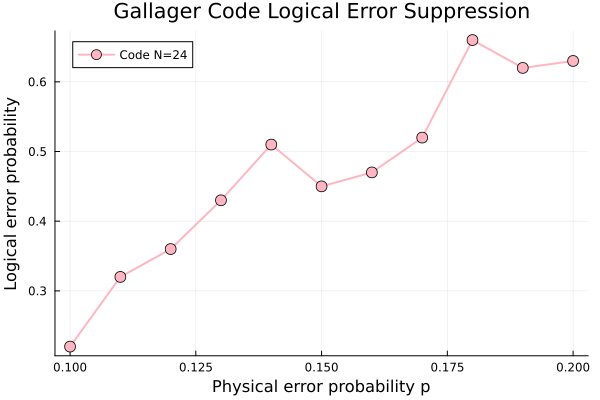

In [25]:
d_v = 3
d_c = 4
num_batches = 20
samples_per_batch = 5
N_Ar = [24]
colors = Plots.cgrad(:reds, length(N_Ar)).colors  # Use a red gradient
ps = 0.1:0.01:0.2
plt = plot()

for (i, N) in enumerate(N_Ar) 
    logical_probs = [loops_regular_code_sim_batched(N, d_v, d_c, p, num_batches, samples_per_batch; pbias = 0.1, max_loop_order = 8) for p in ps]
    plot!(plt, ps, logical_probs;
          label="Code N=$N",
          lw=2,
          color=colors[i],
          marker=:circle,
          markersize=6,
          linestyle=:solid)
end

xlabel!("Physical error probability p")
ylabel!("Logical error probability")
title!("Gallager Code Logical Error Suppression")


## Not using

p = 0.15, N = 20, batches = 40, samples per batch = 20
p = 0.16, N = 20, batches = 40, samples per batch = 20
p = 0.17, N = 20, batches = 40, samples per batch = 20
p = 0.18, N = 20, batches = 40, samples per batch = 20
p = 0.19, N = 20, batches = 40, samples per batch = 20
p = 0.2, N = 20, batches = 40, samples per batch = 20
p = 0.15, N = 40, batches = 40, samples per batch = 20
p = 0.16, N = 40, batches = 40, samples per batch = 20
p = 0.17, N = 40, batches = 40, samples per batch = 20
p = 0.18, N = 40, batches = 40, samples per batch = 20
p = 0.19, N = 40, batches = 40, samples per batch = 20
p = 0.2, N = 40, batches = 40, samples per batch = 20


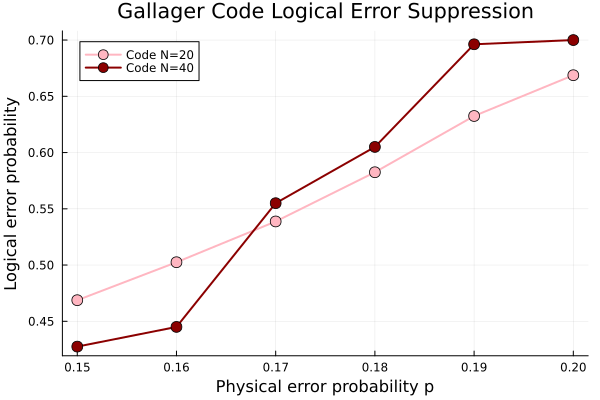

In [24]:
function check_loops_(dataindex, pcmat)
    checks = get_nbrs_of_data(pcmat,dataindex)
    loops = []
    for c1 in checks
        for c2 in checks 
            if c1 >= c2
                continue 
            end 
            nbrs1 = get_nbrs_of_check(pcmat,c1)
            nbrs2 = get_nbrs_of_check(pcmat,c2)
            commons = [d for d in nbrs1 if (d in nbrs2 && d != dataindex)]
            for d in commons
                push!(loops, Dict("datas"=>([dataindex, d]), "checks"=> ([c1,c2])))
            end
        end 
    end 
    return loops 
end 

function local_sample(data_tensors,syn_tensors,adj_mat,messages,d)
    probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d)
    ix = inds(probs)[1]
    probs = [real(probs[ix=>n]) for n in 1:dim(ix)]
    probs ./= sum(probs)
    error_i = sample_bit(probs[1])
    return error_i 
end 

function correlated_probs(pcmat,loop,data_tensors,syn_tensors,messages,edges, links, adj_mat)
    m, n = size(pcmat)
    localc1 = syn_tensors[loop["checks"][1]] 
    for d in get_nbrs_of_check(pcmat,loop["checks"][1])
        if !(d in loop["datas"])
            localc1 = localc1 * messages[d,n+loop["checks"][1]]
        end 
    end 
    

    localc2 = syn_tensors[loop["checks"][2]] 
    for d in get_nbrs_of_check(pcmat,loop["checks"][2])
        if !(d in loop["datas"])
            localc2 = localc2 * messages[d,n+loop["checks"][2]]
        end 
    end 

    locald1 = data_tensors[loop["datas"][1]] 
    for c in get_nbrs_of_data(pcmat,loop["datas"][1])
        if !(c in loop["checks"])
            locald1 = locald1 * messages[n+c,loop["datas"][1]]
        end 
    end 

    locald2 = data_tensors[loop["datas"][2]] 
    for c in get_nbrs_of_data(pcmat,loop["datas"][2])
        if !(c in loop["checks"])
            locald2 = locald2 * messages[n+c,loop["datas"][2]]
        end 
    end 
    
    uncorr = (messages[loop["checks"][1]+n,loop["datas"][1]] * locald1 * messages[loop["checks"][2]+n,loop["datas"][1]] ) * ((messages[loop["checks"][1]+n,loop["datas"][2]] * locald2 * messages[loop["checks"][2]+n,loop["datas"][2]] ))
    normchek = (messages[loop["datas"][1],loop["checks"][1]+n] * localc1 * messages[loop["datas"][2],loop["checks"][1]+n] ) * ((messages[loop["datas"][1],loop["checks"][2]+n] * localc2 * messages[loop["datas"][2],loop["checks"][2]+n] ))

    localc2 = prime(localc2, inds(localc2))
    localc1 = prime(localc1, inds(localc1))


    corrd = locald1 * BP.excited_edge((loop["datas"][1],n + loop["checks"][1]), messages, edges, links, adj_mat) * localc1 * BP.excited_edge((loop["datas"][2],n + loop["checks"][1]), messages, edges, links, adj_mat) * locald2 * BP.excited_edge((loop["datas"][2],n + loop["checks"][2]), messages, edges, links, adj_mat) * localc2 * BP.excited_edge((loop["datas"][1],n + loop["checks"][2]), messages, edges, links, adj_mat)
    # uncorr = prime(uncorr, inds(uncorr))
    tots =   uncorr  + corrd / scalar(normchek)
    probs = [tots[ii,jj] for ii in 1:2 for jj in 1:2]
    probs = probs ./ sum(probs)
    println(probs)
    return real.(probs)
end 

In [ ]:
d_v = 3 
d_c = 4
ps = 0.02:0.01:0.2
num_samples = 200
N_Ar = [20,40]
colors = Plots.cgrad(:reds, length(N_Ar)).colors  # Use a red gradient

plt = plot()

for (i, N) in enumerate(N_Ar) 
    logical_probs = [regular_code_sim_simple(N, d_v, d_c, p, num_samples) for p in ps]
    plot!(plt, ps, logical_probs;
          label="Code N=$N",
          lw=2,
          color=colors[i],
          marker=:circle,
          markersize=6,
          linestyle=:solid)
end

xlabel!("Physical error probability p")
ylabel!("Logical error probability")
title!("Gallager Code Logical Error Suppression")
function loops_regular_code_sim_simple(n, d_v, d_c, p, num_samples; pbias = 0.1)
    println("p = $p, N = $n")
    logical_error_count = 0
    nsamp = 0
    for _ in 1:num_samples
        pcmat = gallager_ldpc_matrix(n, d_v, d_c)
        m, n = size(pcmat)
        k = n - m
        # Sample errors iid with probability p
        errors_true = [sample_bit(1-p) for _ in 1:n]
        # Compute syndrome
        syndrome = pcmat * errors_true .% 2
        # Decode using the code above
        data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome)
        errors = Int.(-1 .* ones(n))
        tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = pbias), syn_tensors)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors,edges,links) 
        messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)

        for d = 1:n
            loops = check_loops_(d, pcmat)
            probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d)
            for loop in loops
                loop_ = [(loop["datas"][1],n + loop["checks"][1]),(loop["datas"][2],n + loop["checks"][1]),(loop["datas"][1],n + loop["checks"][2]),(loop["datas"][2],n + loop["checks"][2])]
                mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; pbias = pbias, exclude=[d]), syn_tensors)
                probs += loop_contribution(loop_, messages, mtensors, edges, links, adj_mat) / (get_marginal(mtensors,adj_mat,messages,n+loop["checks"][1]) * get_marginal(mtensors,adj_mat,messages,n+loop["checks"][2]) * get_marginal(mtensors,adj_mat,messages,loop["datas"][2]))
            end 
            ix = inds(probs)[1]
            probs = [real(probs[ix=>n]) for n in 1:dim(ix)]
            probs ./= sum(probs)
            error_i = sample_bit(probs[1])
            errors[d] = error_i
        end        
        logical_error_count += (sum(errors .!= errors_true) > 0)
        nsamp += 1 
    end
    return logical_error_count / nsamp
end